In [13]:
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
import torch

from scipy.linalg import expm, toeplitz
from numpy.linalg import inv, eig, lstsq, norm
from numpy.fft import fft, fftshift

In [14]:
cutoff = 30
Layer = namedtuple('Layer', 'dielectric z')

In [15]:
def constructToeplitz(dielec, a1):
    xvals = np.linspace(0, a1, 8*cutoff+1, endpoint=False)
    yvals = list(map(dielec, xvals))
    yfft = fftshift(fft(yvals))/(8*cutoff+1)
    positive_vals = yfft[4*cutoff : 6*cutoff+1]
    negative_vals = yfft[2*cutoff : 4*cutoff+1][::-1]
    return toeplitz(r = negative_vals, c = positive_vals)

In [17]:
iden = np.identity(2*cutoff+1, dtype=complex)

def branchedSquareRoot(list_of_vals):
    list_of_roots = []
    for z in list_of_vals:
        if np.abs(np.imag(z)) < 1e-7: # if there is almost no imaginary part
            if np.real(z) >= 0:
                list_of_roots.append(np.sqrt(z)) # normal square root
            else:
                list_of_roots.append(1.0j*np.sqrt(-np.real(z))) # positive branch!!!

        else:
            list_of_roots.append(np.sqrt(z)) # otherwise choose the positive real branch.
            # this correctly assigns the forward propagating modes to 

    return np.array(list_of_roots)


def constructOmegaTE(layer, k0, kx, a1):
    eps = constructToeplitz(layer.dielectric, a1)
    omega_sq = k0**2*eps - kx @ kx
    eigvals, eigvecs = eig(omega_sq)
    omega = eigvecs @ np.diag(branchedSquareRoot(eigvals)) @ inv(eigvecs)
    return omega

The boundary conditions are very elegant when written in block diagonal form.
Denote the coefficients of the wavefunctions as $a^+_{i}$ for the transmitting modes in layer $i$, and $a^-_{i}$ for the reflected layer.  Our goal will be to calculate $M$ where $a^-_{i} = Ma^+_{i}$, which is the reflection matrix.

The boundary conditions between two layers at $z_i$ read 
$$
\begin{bmatrix} e^{i\Omega_i z_i} & e^{-i\Omega_i z_i} \\
\Omega_i e^{i\Omega_i z_i} & -\Omega_i e^{-i\Omega_i z_i}
\end{bmatrix} \begin{bmatrix} a_{i}^+ \\ a_{i}^- \end{bmatrix} =
\begin{bmatrix} e^{i\Omega_{i+1} z_i} & e^{-i\Omega_{i+1} z_i} \\
\Omega_{i+1} e^{i\Omega_{i+1} z_i} & -\Omega_{i+1} e^{-i\Omega_{i+1} z_i}
\end{bmatrix} \begin{bmatrix} a_{i+1}^+ \\ a_{i+1}^- \end{bmatrix} 
$$

Define ${\tilde a}_i^+ = e^{i\Omega_i z_i} a_i^+$ and ${\tilde a}_i^- = e^{-i\Omega_i z_i} a_i^-$.  Then the matrix equation reads
$$
\begin{bmatrix} I & I \\
\Omega_i & -\Omega_i
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i}^+ \\ {\tilde a}_{i}^- \end{bmatrix} =
\begin{bmatrix} e^{i\Omega_{i+1} (z_i - z_{i+1})} & e^{-i\Omega_{i+1} (z_i - z_{i+1})} \\
\Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} & -\Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})}
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i+1}^+ \\ {\tilde a}_{i+1}^- \end{bmatrix} 
$$

with the advantage that the omegas are slightly better behaved, as the thickness is smaller than the total distance.  

Now, we relate the matrices to one another in the transfer matrix formalism.  Let us work backwards: suppose that the two coefficients ${\tilde a}^+_{i+1}$ and ${\tilde a}^-_{i+1}$ are related by ${\tilde a}^-_{i+1} = M_{i+1} {\tilde a}^+_{i+1}$.  For the very final layer, $M_f = 0$, as there are no incoming modes.  We are using the convention that $z_i < z_{i+1}$, that is, the $z$ is increasing starting from $0$, which is the surface.  The equations read

$$
\begin{bmatrix} I & I \\
\Omega_i & -\Omega_i
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i}^+ \\ {\tilde a}_{i}^- \end{bmatrix} =
\begin{bmatrix} e^{i\Omega_{i+1} (z_i - z_{i+1})} & e^{-i\Omega_{i+1} (z_i - z_{i+1})} \\
\Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} & -\Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})}
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i+1}^+ \\ M_{i+1} {\tilde a}_{i+1}^+ \end{bmatrix} 
$$
which means
$$
\begin{bmatrix} I & I \\
\Omega_i & -\Omega_i
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i}^+ \\ {\tilde a}_{i}^- \end{bmatrix} =
\begin{bmatrix} e^{i\Omega_{i+1} (z_i - z_{i+1})} + e^{-i\Omega_{i+1} (z_i - z_{i+1})} M_{i+1} \\
\Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} -\Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})} M_{i+1}
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i+1}^+  \end{bmatrix}.  $$
Define 
$$
A_{i+1} = e^{i\Omega_{i+1} (z_i - z_{i+1})} + e^{-i\Omega_{i+1} (z_i - z_{i+1})} M_{i+1}, \\
B_{i+1} = \Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} -\Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})} M_{i+1}.
$$  

Our goal will be to calculate $BA^{-1}$, but we need to do it in a way that appropriately takes care of the possibly ill-conditioned matrix 
$$
e^{i\Omega_{i+1} (z_i - z_{i+1})}
$$, 
which may have extremely large eigenvalues.  To treat this, notice that if we factor out the exponential,

$$
A_{i+1} = \left[I + e^{-i\Omega_{i+1} (z_i - z_{i+1})} M_{i+1} e^{-i\Omega_{i+1} (z_i - z_{i+1})}\right] e^{i\Omega_{i+1} (z_i - z_{i+1})} , \\
B_{i+1} = \Omega_{i+1} \left[I - e^{-i\Omega_{i+1} (z_i-z_{i+1})} M_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})} \right] e^{i\Omega_{i+1} (z_i - z_{i+1})} .
$$  

Now $BA^{-1}$ reads
$$
B_{i+1} A_{i+1}^{-1} = \Omega_{i+1} \left[I - e^{-i\Omega_{i+1} (z_i - z_{i+1})} M_{i+1} e^{-i\Omega_{i+1} (z_i - z_{i+1})}\right] \left[I + e^{-i\Omega_{i+1} (z_i-z_{i+1})} M_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})} \right]^{-1}
$$
with the advantage that the new exponentials should be tiny compared to $I$, so this quantity should be very well defined.

We need to find $M_i$ in terms of $M_{i+1}$.  To do this,
$$
\begin{bmatrix} I & I \\
\Omega_i & -\Omega_i
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i}^+ \\ {\tilde a}_{i}^- \end{bmatrix} =
\begin{bmatrix} A_{i+1} \\
B_{i+1}
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i+1}^+  \end{bmatrix}.  $$
This means
$$
{\tilde a}_{i}^+ + {\tilde a}_{i}^- = A_{i+1} {\tilde a}_{i+1}^+, \\
\Omega_i {\tilde a}_{i}^+ - \Omega_i {\tilde a}_{i}^- = B_{i+1} {\tilde a}_{i+1}^+ \\
\Omega_i {\tilde a}_{i}^+ - \Omega_i {\tilde a}_{i}^- = B_{i+1} A_{i+1}^{-1} ({\tilde a}_{i}^+ + {\tilde a}_{i}^-)\\
(-\Omega_i - B_{i+1} A_{i+1}^{-1}) a_i^- = (-\Omega_i + B_{i+1} A_{i+1}^{-1}){\tilde a}_{i}^+ \\
$$
So our new matrix is
$$
M_i = [\Omega_i + B_{i+1} A_{i+1}^{-1}]^{-1} [\Omega_i - B_{i+1} A_{i+1}^{-1}]
$$


In [44]:
def constructMMatrxTE(mB, layerA, layerB, k0, kx, a1):
    omegaA = constructOmegaTE(layerA, k0, kx, a1)
    omegaB = constructOmegaTE(layerB, k0, kx, a1)
    zA = layerA.z
    zB = layerB.z
    exp_omegaB = expm(-1.0j*omegaB*(zA-zB))
    conjugatemB = exp_omegaB @ mB @ exp_omegaB
    bainv =  omegaB @ (iden - conjugatemB) @ inv(iden + conjugatemB)
    ma = inv(omegaA + bainv) @ (omegaA - bainv)
    return ma
    

In [55]:
reflectance = []

for wavelength in range(200,1500,2):

    k0 = 2*np.pi/wavelength*1000
    lattice = 0.2
    deg = np.pi/180.0
    theta = 70 * deg
    n1 = 1.0 # index of refraction of first medium
    a1 = 0.2
    kx_incident = n1 * np.sin(theta)
    cutoff = 30

    kx_inc = k0 * n1 * np.sin(theta) # conserved mod 2pi/a1
    kx = np.diag([kx_inc - 2*np.pi*m/a1 for m in range(-cutoff, cutoff+1)])


    layer1 = Layer(lambda x: 1.0, 0.0)
    layer2 = Layer(lambda x: 1.0 if x + 1e-7 % a1 < a1/2 else 25.0, 0.1)
    layer2_5 = Layer(lambda x: 1.0 if x + 1e-7 % a1 < a1/2 else 25.0, 0.2)
    layer3 = Layer(lambda x: 25.0, 0.2) # this very last value does not enter in the calculation

    mom = constructMMatrxTE(np.zeros((2*cutoff+1, 2*cutoff+1), dtype=complex), layer2_5, layer3, k0, kx, a1)
    mom2_5 = constructMMatrxTE(mom, layer2, layer2_5, k0, kx, a1)
    mom2 = constructMMatrxTE(mom2_5, layer1, layer2, k0, kx, a1)

    reflectance.append(mom2[cutoff,cutoff])

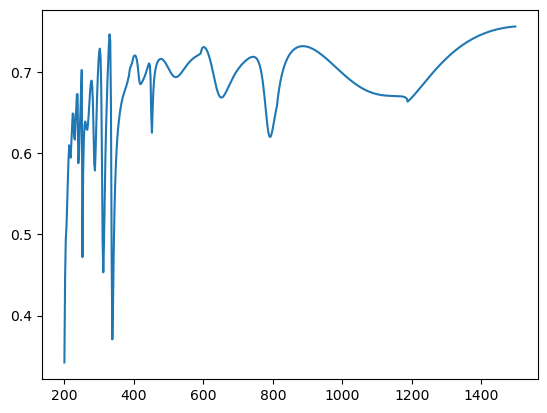

In [56]:
plt.plot(np.array(range(200,1500,2)), np.abs(reflectance)**2)

In [36]:
def constructOmegaTM(layer, k0, kx, a1):
    eps = constructToeplitz(layer.dielectric, a1)
    inv_eps = constructToeplitz(lambda x : 1.0/layer.dielectric(x), a1)
    omega_sq = inv(inv_eps) @ (k0**2 * iden - kx @ inv(eps) @ kx)
    eigvals, eigvecs = eig(omega_sq)
    omega = eigvecs @ np.diag(branchedSquareRoot(eigvals)) @ inv(eigvecs)
    return omega, inv_eps

In [37]:
def constructMMatrxTM(mB, layerA, layerB, k0, kx, a1):
    omegaA, inv_eps_A = constructOmegaTM(layerA, k0, kx, a1)
    omegaB, inv_eps_B = constructOmegaTM(layerB, k0, kx, a1)
    zA = layerA.z
    zB = layerB.z
    exp_omegaB = expm(-1.0j*omegaB*(zA-zB))
    conjugatemB = exp_omegaB @ mB @ exp_omegaB
    bainv =  inv_eps_B @ omegaB @ (iden - conjugatemB) @ inv(iden + conjugatemB)
    ma = inv(inv_eps_A @ omegaA + bainv) @ (inv_eps_A @ omegaA - bainv)
    return ma
    

In [38]:
reflectance = []

for wavelength in range(200,1500,2):

    k0 = 2*np.pi/wavelength*1000
    lattice = 0.2
    deg = np.pi/180.0
    theta = 70 * deg
    n1 = 1.0 # index of refraction of first medium
    a1 = 0.2
    kx_incident = n1 * np.sin(theta)
    cutoff = 30

    kx_inc = k0 * n1 * np.sin(theta) # conserved mod 2pi/a1
    kx = np.diag([kx_inc - 2*np.pi*m/a1 for m in range(-cutoff, cutoff+1)])

    layer1 = Layer(lambda x: 1.0, 0.0)
    layer2 = Layer(lambda x: 1.0 if x + 1e-7 % a1 < a1/2 else 25.0, 0.1)
    layer2_5 = Layer(lambda x: 1.0 if x + 1e-7 % a1 < a1/2 else 25.0, 0.2)
    layer3 = Layer(lambda x: 25.0, 0.2) # this very last value does not enter in the calculation

    mom = constructMMatrxTM(np.zeros((2*cutoff+1, 2*cutoff+1), dtype=complex), layer2_5, layer3, k0, kx, a1)
    mom2_5 = constructMMatrxTM(mom, layer2, layer2_5, k0, kx, a1)
    mom2 = constructMMatrxTM(mom2_5, layer1, layer2, k0, kx, a1)

    reflectance.append(mom2[cutoff,cutoff])

In [52]:
def compileTE(layers, k0, kx, a1):
    m0 = np.zeros((2*cutoff+1, 2*cutoff+1), dtype=complex)
    assert len(layers) > 1

    for i in range(len(layers)-1):
        current_layer_B = len(layers) - i - 1
        current_layer_A = len(layers) - i - 2

        m0 = constructMMatrxTE(m0, layers[current_layer_A], layers[current_layer_B], k0, kx, a1)
    
    return m0

def compileTM(layers, k0, kx, a1):
    m0 = np.zeros((2*cutoff+1, 2*cutoff+1), dtype=complex)
    assert len(layers) > 1

    for i in range(len(layers)-1):
        current_layer_B = len(layers) - i - 1
        current_layer_A = len(layers) - i - 2

        m0 = constructMMatrxTM(m0, layers[current_layer_A], layers[current_layer_B], k0, kx, a1)
    
    return m0


In [57]:
layerList = [layer1, layer2_5, layer3]

reflectanceTE = []
reflectanceTM = []

for wavelength in range(200,1500,2):
    

    k0 = 2*np.pi/wavelength*1000
    lattice = 0.2
    deg = np.pi/180.0
    theta = 70 * deg
    n1 = 1.0 # index of refraction of first medium
    a1 = 0.2
    kx_incident = n1 * np.sin(theta)
    cutoff = 30

    kx_inc = k0 * n1 * np.sin(theta) # conserved mod 2pi/a1
    kx = np.diag([kx_inc - 2*np.pi*m/a1 for m in range(-cutoff, cutoff+1)])


    momTE = compileTE(layerList, k0, kx, a1)
    momTM = compileTM(layerList, k0, kx, a1)

    reflectanceTE.append(momTE[cutoff,cutoff])
    reflectanceTM.append(momTM[cutoff,cutoff])



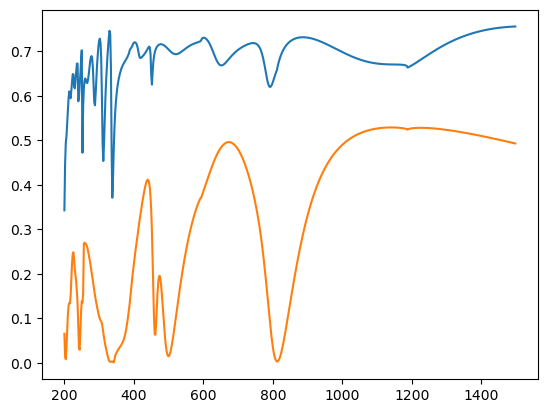

In [58]:
plt.plot(np.array(range(200,1500,2)), np.abs(reflectanceTE)**2)
plt.plot(np.array(range(200,1500,2)), np.abs(reflectanceTM)**2)

Rearranging the terms to get a scattering matrix form:

$$
\begin{bmatrix} I & -e^{-i\Omega_{i+1} (z_i - z_{i+1})} \\
\Omega_i & \Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})}
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i}^+ \\ {\tilde a}_{i+1}^- \end{bmatrix} =
\begin{bmatrix} e^{i\Omega_{i+1} (z_i - z_{i+1})} & -I \\
\Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} & \Omega_i
\end{bmatrix} \begin{bmatrix} {\tilde a}_{i+1}^+ \\ {\tilde a}_{i}^- \end{bmatrix} 
$$

We'll thus define the scattering matrix to be

$$
S_i = \text{lstsq}\left(\begin{bmatrix} I & -e^{-i\Omega_{i+1} (z_i - z_{i+1})} \\
\Omega_i & \Omega_{i+1} e^{-i\Omega_{i+1} (z_i-z_{i+1})}
\end{bmatrix},
\begin{bmatrix} e^{i\Omega_{i+1} (z_i - z_{i+1})} & -I \\
\Omega_{i+1} e^{i\Omega_{i+1} (z_i - z_{i+1})} & \Omega_i
\end{bmatrix} \right)
$$,
where $\text{lstsq}(A, B)$ solves the system $Ax = B$ and returns $x$.  The least squares command is more robust than inverting $A$, especially when values are singular.

Because we have absorbed non-unit factors into the coefficients $a_\pm$, it will be likely that the scattering matrix will not be unitary.  What is unitary, however, will be the relation between the incoming and outgoing modes.

In [54]:
def constructScatteringMatrixTE(layerA, layerB):
    omegaA = constructOmegaTE(layerA)
    omegaB = constructOmegaTE(layerB)
    zA = layerA.z
    zB = layerB.z
    print(zA - zB)
    expBp = expm(1.0j * omegaB * (zA - zB))
    expBm = expm(-1.0j * omegaB * (zA - zB))

    Amat = np.block([[iden, -expBm],\
                   [omegaA, omegaB @ expBm]])
    
    Bmat = np.block([[expBp, -iden],\
                     [omegaB @ expBp, omegaA]])
    
    print(norm(Amat))
    print(norm(Bmat))
    
    return lstsq(Amat, Bmat)

In [55]:
s1 = constructScatteringMatrixTE(layer1, layer3)

0.0
3365.997527101079
3365.997527101079


C:\Users\aaron\AppData\Local\Temp\ipykernel_9664\2783140554.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return lstsq(Amat, Bmat)


In [51]:
incoming = np.zeros((4*cutoff+2, 1))
incoming[cutoff,0] = 1

In [ ]:
kx_inc = n1 * np.sin(theta)
reflectance = []
iden = np.identity(2*cutoff+1, dtype=complex)

for wavelength in range(200,1400,200):
    k0 = 2*np.pi/wavelength
    a1 = 0.2 * k0
    depth1 = 0.2*k0
    cutoff = 50

    layer1 = Layer(lambda x: 1.0, 0.0)
    layer2 = Layer(lambda x: 1.0 if x + 1e-7 % a1 < a1/2 else 11.0, depth1)
    layer3 = Layer(lambda x: 11.0, depth1)
    
     # conserved mod 2pi/a1
    kx = np.diag([kx_inc - 2*np.pi*m/a1 for m in range(-cutoff, cutoff+1)])

    mom = constructMMatrx(np.zeros((2*cutoff+1, 2*cutoff+1), dtype=complex), layer2, layer3)
    mom2 = constructMMatrx(mom, layer1, layer2)

    reflectance.append(mom2[cutoff][cutoff])

In [ ]:
def constructTransferMatrixTE(layerA, layerB):
    omegaA = constructOmegaTE(layerA)
    omegaB = constructOmegaTE(layerB)
    zA = layerA.z
    zB = layerB.z
    print(zA - zB)
    expBp = expm(1.0j * omegaB * (zA - zB))
    expBm = expm(-1.0j * omegaB * (zA - zB))

    Amat = np.block([[iden, iden],\
                   [omegaA, -omegaA]])
    
    Bmat = np.block([[expBp, expBm],\
                     [omegaB @ expBp, -omegaB @ expBm]])
    
    print(norm(Amat))
    print(norm(Bmat))
    
    return lstsq(Amat, Bmat)